In [1]:
from matplotlib import pyplot as plt

import numpy as np
import cv2 as cv

In [2]:
file = './videos/news.mpg'

In [3]:
def get_metrics(file, difference, params):
    cap = cv.VideoCapture(file)

    metrics = []

    ret, frame = cap.read()
    old_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY).astype('int16')

    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY).astype('int16')
            metrics.append(difference(gray_frame, old_frame, params))
            old_frame = gray_frame
        else:
            cap.release()
            break

    return metrics


In [4]:
def diff_pixels(frameA, frameB, params):
    diff = abs(frameA - frameB)
    return np.where(diff > params[0], 1, 0).sum()


[mpeg1video @ 0x557a6c9693c0] ac-tex damaged at 0 10
[mpeg1video @ 0x557a6c9693c0] Warning MVs not available


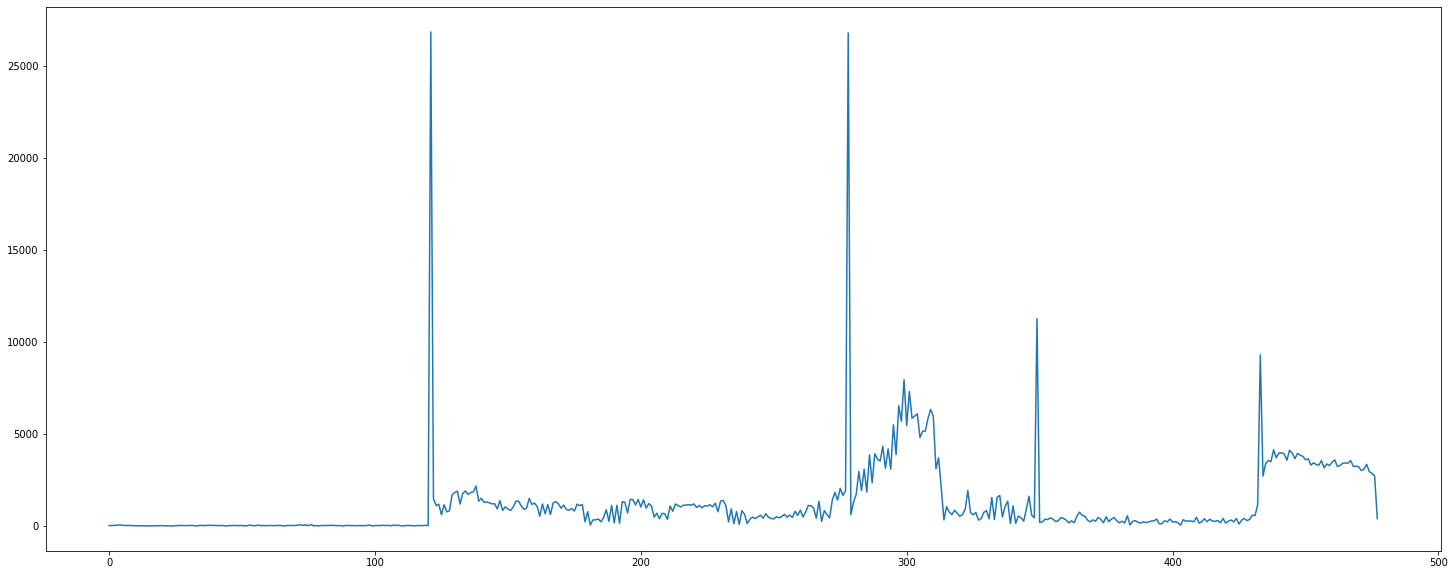

In [5]:
Y = np.array(get_metrics(file, diff_pixels, [128]))
X = range(len(Y))

plt.figure(figsize=(25,10))
plt.plot(X, Y)

In [6]:
def save_metrics(file, output, metrics):
    cap = cv.VideoCapture(file)

    width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    
    fourcc = cv.VideoWriter_fourcc(*'DIVX')
    out = cv.VideoWriter(output, fourcc, 20.0, (width,  height))

    count = 0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            if count < len(metrics) and metrics[count]:
                out.write(frame)
        else:
            cap.release()
            out.release()
            break
        count += 1


In [7]:
save_metrics(file, './videos/output.avi', Y > 3000)

[mpeg1video @ 0x557a6c9bd200] ac-tex damaged at 0 10
[mpeg1video @ 0x557a6c9bd200] Warning MVs not available
